In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import re
import math
from nltk.sentiment import SentimentIntensityAnalyzer

## sentiment analysis

In this notebook, we will analyze the sentiment of each document and the sentiment for each topic.
Later, we will analyze the change of sentiment along time, we only consider the comments within certain time period after a post being posted. 

First, we will study the time difference between the posting date of a post and its comment.


In [31]:
## load the data
posts_df = pd.read_csv('new_posts_8.csv',index_col = 'post_id')

cols = ['comment_post_id', 'comment_author', 'comment_date','comment_body', 'comment_up_votes','comment_replies_count']
comments_df = pd.read_csv('new_comments_8.csv',usecols = cols)

In [13]:
posts_df.head()

,post_flair,post_title,post_date,post_url,post_body,post_up_votes,post_commentaries_count,post_awards_count,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,loss
post_id,,,,,,,,,,,,,,,,,
idqwwi,Cosplay,Walking Around Night City on November 19th Lik...,2020-08-21,https://v.redd.it/caa7ofozkai51,NaN,5805,154,1,0.054496,0.000000,0.019361,0.086822,0.701345,0.076130,0.049031,0.012814,0.900026
iv98fz,Question,PC Specs Megathread - Please use this thread t...,2020-09-18,https://www.reddit.com/r/cyberpunkgame/comment...,Hey Choombas\n\nDuring Night City Wire Epi...,763,521,8,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.680262
j0sngm,Video,New Gunplay from TGS 2020,2020-09-27,https://v.redd.it/ccnxl54ihpp51,NaN,3959,208,18,0.166985,0.000000,0.226643,0.174818,0.007391,0.422898,0.000000,0.001266,0.950502
j294ea,News,CD Projekt Red is breaking their promise of no...,2020-09-29,https://twitter.com/jasonschreier/status/13110...,NaN,25420,568,37,0.860978,0.000000,0.000000,0.000000,0.000000,0.000000,0.139022,0.000000,0.924466
j2tllo,Question,"Can someone explain to me how much stress, pai...",2020-09-30,https://www.reddit.com/r/cyberpunkgame/comment...,I just can't seem to understand why people are...,360,180,3,0.762134,0.041619,0.000000,0.000000,0.021112,0.000000,0.163299,0.011836,0.948879


In [14]:
comments_df.head()

,comment_post_id,comment_author,comment_date,comment_body,comment_up_votes,comment_replies_count
0,idqwwi,t2_2hnv8ktm,2020-08-21,LMFAO!!! I am one of those guys who have the R...,2,0
1,idqwwi,t2_33sm1qon,2020-08-21,I basically purchased some led strips and glue...,2,0
2,idqwwi,t2_33sm1qon,2020-08-21,its a mod for PC only...gives a more irl exper...,3,0
3,idqwwi,t2_33sm1qon,2020-08-21,Gotta keep it real and genuine,2,0
4,idqwwi,t2_33sm1qon,2020-08-21,"Those are very humbling words fam, Thank You!",2,0


In [15]:
## analysis the date difference 

## here both date1 and date2 are strings
def str2num(s):
    if s[0] == '0':
        n_s = s.replace('0','',1)
        return int(n_s)
    else:
        return int(s)

def date_difference(date1, date2):
    a = '([0-9]{4})-([0-9]{2})-([0-9]{2})'
    (y1,m1,d1) = re.search(a, date1).groups()
    (y2,m2,d2)= re.search(a,date2).groups()
    y_diff = str2num(y2) - str2num(y1)
    m_diff = str2num(m2) -str2num(m1)
    d_diff = str2num(d2) - str2num(d1)

    ## change the difference to days, because the accuracy requirement is not so high
    ## so we assume 365 days per year
    days_month = (31,28,31,30,31,30,31,31,30,31,30,31)
    b = y_diff *12 + m_diff
    if b <= 0:
        return d_diff 
    else:
        sum = 0
        for i in range(b-1):
            sum += days_month[str2num(m1)-1+i]
        diff = sum + d_diff + days_month[(str2num(m2)-2)%12] 
        return diff 


## update the time range of the comments.
## first check whether the difference between the first comment date and the post date are less or equal than 1 days,
def date_range(posts_df, comments_df):
    
    for post in posts_df.index:
            date0 = posts_df.loc[post, 'post_date']
            dates = comments_df[comments_df['comment_post_id'] == post]['comment_date'].to_numpy()
            diff = [date_difference(date0, date) for date in dates]
            comments_df.loc[comments_df['comment_post_id'] == post,'date_difference'] = diff
            date1 = np.max(diff)
            date2 = np.min(diff)

            ## first check whether the first comment date and the post date are posted at the same day, we can see for most posts
            ## the first comment is posted as the same day as the post, no later than 2 days.
            
            if date2 != 0:
                print(post, date0, date2)
                
            posts_df.loc[post,'comments_date_range'] = date1 - date2 + 1 
            # num_authors = len(df['comment_author'].unique()) 
            # posts_df.loc[post,'num_comment_authors'] = num_authors


In [32]:
date_range(posts_df, comments_df)
## for almost all posts, the first comment is posted in the same day as the post

comments_df['date_difference'].describe()
## most comments are posted within 2 days of the post posted

comments_df[comments_df['date_difference'] > 2].describe()
# As we can see few comments are posted after (including) *3* days of the original post dates, $2441/183750$.
#  Among these late posts, the number of up_votes for each post is also no so high averagely.
#  So we can delete this comments and update the data.

k5oqbw 2020-12-02 1
k8vxao 2020-12-07 1
kbd0au 2020-12-11 2
kc2vjr 2020-12-12 1
kzljqg 2021-01-17 1
l098zh 2021-01-18 1
l33ivn 2021-01-22 1
l3qxwz 2021-01-23 1
l4duvz 2021-01-24 1
l92hiv 2021-01-30 1
l9sh6y 2021-01-31 1
lex2bb 2021-02-07 1


,comment_up_votes,comment_replies_count,date_difference
count,2441.000000,2441.000000,2441.000000
mean,3.609177,0.595658,9.498566
std,7.308853,1.432914,8.416909
min,-2.000000,0.000000,3.000000
25%,2.000000,0.000000,4.000000
50%,2.000000,0.000000,6.000000
75%,3.000000,1.000000,13.000000
max,222.000000,19.000000,86.000000


In [23]:
## refine comments and posts according to the date difference and the number of up_votes.
## we only keep the comments with up_vote > 5, also the up_votes number is among first 50% of all comments of that post

def update_comments(posts_df, comments_df,date_threshold = 3, threshold1 = 0.5, threshold2 = 5):
        
    n_comments_df = comments_df.copy()
    n_comments_df = n_comments_df[n_comments_df['date_difference'] < date_threshold]
    n_comments_df = n_comments_df[n_comments_df['comment_up_votes'] > threshold2]
    
    ## update the number of comments for each post
    drop_index = []
    for post in posts_df.index:   
            df = (n_comments_df.loc[n_comments_df['comment_post_id'] == post, 'comment_up_votes'].abs()).sort_values(ascending = False) 
            # try:
            #     print(df.iloc[math.floor(len(df)*threshold1)])
            # except:
            #     print(post, math.floor(len(df)*threshold1),len(df))
            a = list(df.index)[math.floor(len(df)*threshold1) :]
            drop_index += a
            num_comments = len(df) - len(a)
            posts_df.loc[post,'post_commentaries_count'] = num_comments  
            if num_comments == 0:
                posts_df.drop(post)
                continue

            ## update the comments_range
            b = n_comments_df.loc[n_comments_df['comment_post_id'] == post, 'date_difference'].to_numpy()
            date_range = np.max(b)
            posts_df.loc[post,'comments_date_range'] = date_range

    n_comments_df.drop(drop_index, inplace = True)
    return n_comments_df

In [33]:
# only run it once
comments_df = update_comments(posts_df,comments_df)

In [34]:
## generate sentiment score for each post and each comment
def sentiment_score(df, cols):
    sia = SentimentIntensityAnalyzer()
    for col in cols:
        texts = df[col].to_numpy()
        s = [sia.polarity_scores(t)['compound'] if type(t) == str else None for t in texts]
        df[col+ '_sentiment_score'] = s
               
    return True

In [35]:
sentiment_score(posts_df,['post_title','post_body'])
sentiment_score(comments_df,['comment_body'])

True

We would like to measure the sentiment of all comments of a post. 
Sentiment score for each single comment is already computed and some "weights" consistent with up votes num of each comment need to be defined. The sentiment score for a post coming from comments will be the weighted sum.

1. The first choice is *num_up_votes*. But some comments have comparable many up votes, if weights are just proportional to the up-votes, these comments may bring bias. For example, these comments may not closely relate to the topic of the posts.
We will use the log(up_votes) as weights, if the up_votes number is negative, the weight if -log(|up_votes|).

2. How about *comment_replies_counts*? It is not necessarily consistent with *num_up_votes*, some comments have many replies but fewer up votes. *comment_replies_counts* is not as good as *num_up_votes* to be the "weights". Because maybe few people discuss a lot below a single comment. Because we do not know the nesting relation between comments. It is hard to figure out the authors of the replies. 
But after some explorations, it is hard to find relations bwt the up_votes_counts ant the replies_counts.

In conclusion, we will use log(up_votes) as weights.

In [37]:
## update the comments sentiment score. As mentioned before, the weights will be log up_votes.
##  the function below can also have weight proportional to up votes counts.

def update_comments_sentiment(posts_df, comments_df, weight = 'log' ):
    comment_sentiments = []
    p = comments_df['comment_up_votes'] >= 0
    comments_df.loc[p,'positive'] = 1
    n = comments_df['comment_up_votes'] < 0
    comments_df.loc[n,'positive'] = -1
    log_comments_df = comments_df.copy()

    if weight == 'log':
        # log_comments_df['comment_replies_count'] = np.log(comments_df['comment_replies_count'] +1)
        log_comments_df.loc[p,'comment_up_votes'] = np.log(comments_df.loc[p,'comment_up_votes'] + 1)
        log_comments_df.loc[n ,'comment_up_votes'] = -np.log(-comments_df.loc[n,'comment_up_votes'] + 1)
    
    for post in posts_df.index:
        df = log_comments_df.loc[log_comments_df['comment_post_id'] == post,['comment_body_sentiment_score','comment_up_votes','positive']]
        up_votes = (df['comment_up_votes'].to_numpy())*( df['positive'].to_numpy())
        up_votes = np.divide(df['comment_up_votes'].to_numpy(), up_votes.sum())
        # print(log_votes.sum())
        comment_sentiments.append((up_votes * df['comment_body_sentiment_score'].to_numpy()).sum())
        # print(len(comment_sentiments))
    if weight == 'log':
        posts_df['log_comments_sentiment'] = comment_sentiments
    else:
        posts_df['comments_sentiment'] = comment_sentiments
        return True
    

In [38]:
update_comments_sentiment(posts_df,comments_df,'log')

How about the sentiment score of a post coming from the post title and body?
Many posts do not have post body, while some posts have significantly different scores of post title and body.
After manual check (check below), we find that post body sentiment are much more precise than post title. So we only use post body sentiment score.
The sentiment score for a single post, will be the average of body score and comments score, if body score exists, otherwise, it will be the comments score.

In [39]:
## this function is to print the posts having large difference btw title and body sentiment scores
def check_difference(posts_df, threshold = 0.5):
    df = posts_df.dropna()
    num = 0
    for post in df.index:
        b_score = df.loc[post, 'post_body_sentiment_score']
        p_score = df.loc[post, 'post_title_sentiment_score']
        if abs(b_score - p_score) > threshold:
            num += 1
            print(post)
            print('TITLE')
            print(df.loc[post, 'post_title'])
            print('BODY')
            print(df.loc[post,'post_body'])
            print("title_score: %f , body_score: %f" %(p_score,b_score))
            print("*****")
    print("There are %d such posts." %(num))   

## print out the posts with a large gap between title and body score. 
check_difference(posts_df, 1)


j2tllo
TITLE
Can someone explain to me how much stress, pain and agony will CDPR devs be going through for working an additional 6 days in the next 7 weeks and are getting paid for it?
BODY
I just can't seem to understand why people are hating on this crunch thing so much, I'm sure as hell even the developers don't have a problem with this. After working on a game for over 7 years, an extra 6 working days  should not be a problem to make sure we get the best possible version of the game when it releases.
title_score: -0.836000 , body_score: 0.605100
*****
jj5k1c
TITLE
State of the subreddit amidst the delay
BODY
`Hey Choombas`

Like all of you, the mod team is very disappointed in hearing about the ~~first~~ ~~second~~ third delay of Cyberpunk 2077.

As you can see, the subreddit is currently locked in order to try and stop the sub [from being overwhelmed with spam](https://streamable.com/9spfgr). We will unlock the sub shortly after this post is made, but we are asking you to keep a f

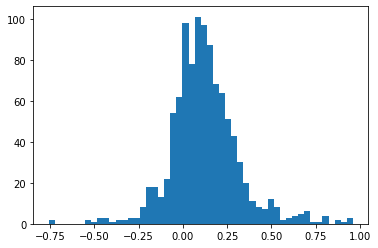

In [19]:
plt.hist(posts_df['log_comments_sentiment'], bins = 50)
plt.show()

To compute the sentiment score for each topic, we firstly need to assign "weights" to each post. 
The same as before, we choose log(up_vote numbers). This time, there is relatively strong corelation between log(up vote num) and log(comments_count). 

We can analysis the topic sentiment in the following way:
Divide the documents into (num_topics + 1) groups by the most likely topic of each document. The extra group consists of documents with similar topic distributions (i.e these documents are hard to be classified as under one topics). The extra group will be discarded. The sentiment scores for each topic will be the sum of sentiment scores for each document.
We need to explore the distribution of topic for documents to divide the documents.

In [52]:
posts_df.columns

Index(['post_flair', 'post_title', 'post_date', 'post_url', 'post_body',
       'post_up_votes', 'post_commentaries_count', 'post_awards_count',
       'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5',
       'topic_6', 'topic_7', 'loss', 'comments_date_range',
       'post_title_sentiment_score', 'post_body_sentiment_score',
       'log_comments_sentiment', 'topic'],
      dtype='object')

In [44]:
# the probability of the most likely topic for each document
# the difference between the most likely topic and the second likely topic

def topics_distribution(posts_df, num_topics = 8):
    cols = ['topic_' + str(i) for i in range(num_topics)]
    tpc_prob = posts_df[cols].to_numpy()
    m_indx = np.argmax(tpc_prob,axis = 1)
    m_prob = np.max(tpc_prob,axis = 1)
    sm_prob = np.sort(tpc_prob, axis = 1)[:,-2]
    d = m_prob - sm_prob


    fig,a = plt.subplots(1,2, figsize = (12,6))
    a[0].hist(m_prob, bins = 50)
    a[0].set_xlabel('probability of the most likely topic')
    a[1].hist(d, bins = 50)
    a[1].set_xlabel('probability difference of the most possible two topics')
    plt.show()

    plt.scatter(m_prob, d)
    plt.xlabel('P of most likely topic')
    plt.ylabel('P diff of most likely two topics')
    plt.show()

    return m_prob, d, m_indx
    





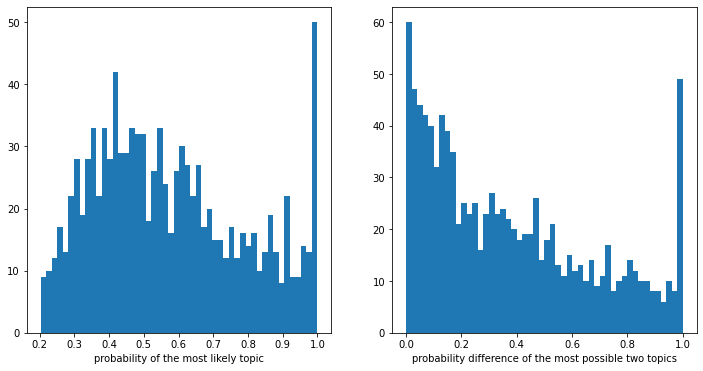

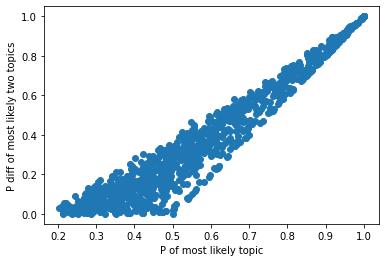

In [50]:
m_prob, d_prob, m_indx = topics_distribution(posts_df)

To divide documents into groups, we keep two kinds of posts:
- The most likely topic having probability > threshold1
- The most likely topic having P between threshold1 and threshold2, the probability difference will be greater then rate_threshold*P

We will filter posts using above criterion, and update topic (with highest probability) for each post. 

In [53]:
def update_topic(posts_df,m_prob,d_prob, m_indx,threshold1 = 0.4, threshold2 = 0.25, rate_threshold = 1/4):
    a1 = m_prob > threshold1
    print(a1.sum())
    a2 = []
    for i in range(len(posts_df)):
        if (m_prob[i] >= threshold2) & (m_prob[i] < threshold1) & (d_prob[i] > rate_threshold * m_prob[i]):
            a2.append(True)
        else:
            a2.append(False)
    ## positions where 
    print(np.array(a2).sum())
    a = np.bitwise_or(a1,np.array(a2))
    # print(a)
    t = [m_indx[i]  for i,p in enumerate(a)if p == True]
    # print(t)
    posts_df.loc[np.bitwise_not(a),'topic'] = - 1
    posts_df.loc[a,'topic'] = t
    return True
    



In [54]:
update_topic(posts_df,m_prob, d_prob, m_indx)

794
104


True

In [55]:
posts_df['topic'].value_counts()

 0.0    227
 7.0    159
-1.0    156
 3.0    140
 1.0    105
 5.0     89
 6.0     63
 2.0     59
 4.0     56
Name: topic, dtype: int64

In [70]:

# if the post_weight is log, the weight is proportional to log of up votes;
# if  post_weight is linear, the weight is proportional to up votes
# if the post weight is none, then all the posts are of equal weights

def topic_sentiment(posts_df, num_topics = 8, post_weight = 'log'):
    sentiments = []
    none_position = posts_df['post_body'].isna().to_numpy()
    ## if there is post_body score, use post_body score; else use comments score
    ## notice the nan multiply by 0 is still nan
    a = posts_df['post_body_sentiment_score'].to_numpy()
    np.nan_to_num(a,copy= False, nan = 0)
    post_sentiments = none_position * posts_df['log_comments_sentiment'].to_numpy() + (1- none_position )* a
    posts_df['sentiment'] = post_sentiments
    # print(post_sentiments)
    weights = posts_df['post_up_votes'].to_numpy()
    if post_weight == 'log':
        weights = np.log(weights)
    elif post_weight == 'none':
        weights = np.ones(len(weights))

    # weights = np.divide(weights,weights.sum())
    # t_sentiment = (post_sentiments + posts_df['log_comments_sentiment']) * weights/2
    
    for i in range(num_topics):
        n = (posts_df['topic'] == i)
        i_weights = np.array([weights[k] for k in range(len(posts_df)) if n[k] ])
        i_weights = np.divide(i_weights,i_weights.sum())
        i_ps = np.array([post_sentiments[k] for k in range(len(posts_df)) if n[k]])
        w_s = (posts_df.loc[n,'log_comments_sentiment'].to_numpy() + i_ps)*i_weights/2
        sentiments.append(w_s.sum())
        
    # if topic_method == 2:
        
    #     cols = ['topic_' + str(i) for i in range(i)]
    #     topics = posts_df[cols].to_numpy()
    #     sentiments = np.multiply(topics, t_sentiment).sum(axis = 0)
    #     avg_sentiments = np.divide(sentiments, topics.sum(axis = 0))

    # fig,axe = plt.subplots(1,2,figsize=(14,7),sharex= True)
    # axe[0].scatter(range(num_topics), sentiments, color = 'blue',marker = '.',alpha = 0.5, label = 'total_sentiment')
    # axe[1].scatter(range(num_topics),avg_sentiments, color = 'red', marker = '^',alpha = 0.5, label = 'average_sentiment')
    # axe[0].legend()
    # axe[1].legend()
    # fig.text(0.5, 0.04, 'topics', ha='center')
    # fig.text(0.04, 0.5, 'sentiment scores', va='center', rotation='vertical')

    return sentiments

In [71]:
nonweights_sentiments =topic_sentiment(posts_df,post_weight='none')

In [72]:
linear_sentiments = topic_sentiment(posts_df,post_weight='linear')

In [73]:
log_sentiments = topic_sentiment(posts_df)

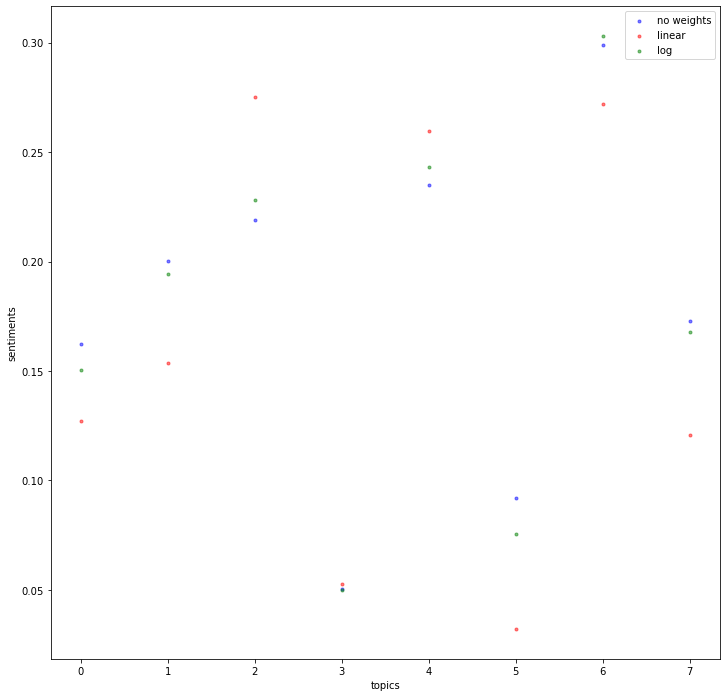

In [74]:
## compare the three different weights
num_topics = 8
plt.figure(figsize = (12,12))

plt.scatter(range(num_topics), nonweights_sentiments, color = 'blue',marker = '.',alpha = 0.5, label = 'no weights')
plt.scatter(range(num_topics), linear_sentiments, color = 'red',marker = '.',alpha = 0.5, label = 'linear')
plt.scatter(range(num_topics), log_sentiments, color = 'green',marker = '.',alpha = 0.5, label = 'log')
plt.xlabel('topics')
plt.ylabel('sentiments')
plt.legend()
plt.show()

even the sentiment scores are different under the same weights, but the relative positions are basically the same. We will stick to the log weights.

The topics are
- 0: about the company - cdpr, news about the game
- 1: romance from the game
- 2: high requirement of hardware to play cyberpunk
- 3: driving or cars from the game
- 4: cosplay inspired from the game
- 5: gun, violent elements of the game
- 6: the release of the game on different platforms
- 7: main character and stories of the game
- 8: reviews from other platform and reviewers

In [150]:
posts_df.to_csv('s_posts_8.csv')
comments_df.to_csv('s_comments_8.csv')